In [34]:
# reload notebook
%load_ext autoreload
%autoreload 2
import jax 
import sys 
sys.path.append("/scr/aliang80/changepoint_aug/changepoint_aug/online_rl_training")
import pickle
import jax.numpy as jnp
import os
import haiku as hk
import matplotlib.animation as animation
from utils import load_maze_data
import pickle
import jax
import torch
import haiku as hk
import numpy as np
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from models import q_fn, vae_fn, decode_fn,  get_prior_fn
from functools import partial
from configs.q_config import get_config as get_q_config
from configs.vae_config import get_config as get_vae_config
from tensorflow_probability.substrates import jax as tfp

dist = tfp.distributions
os.environ['CUDA_VISIBLE_DEVICES'] = '7'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
# get arbitary config 
q_config = get_q_config()
rng_key = jax.random.PRNGKey(0)

data_file = os.path.join(q_config.data_dir, "bc_policy_rollouts_100.pkl")

# load trained q model
with open(q_config.results_file, "rb") as f:
    q_params = pickle.load(f)

vae_config = get_vae_config()

# load vae density model
gc_vae_model_file = os.path.join(vae_config.results_dir, "vae_params_maze_xy_obs.pkl")
with open(gc_vae_model_file, "rb") as f:
    vae_params = pickle.load(f)

print("loading q model from", q_config.results_file)
print("loading vae model from", gc_vae_model_file)

# load dataset
dataset, train_dataloader, test_dataloader, obs_dim, action_dim = (
    load_maze_data(
        data_file,
        batch_size=q_config.batch_size,
        num_trajs=q_config.num_trajs,
        train_perc=q_config.train_perc
    )
)

apply_q_fn = partial(hk.without_apply_rng(q_fn).apply, hidden_size=q_config.hidden_size)
apply_vae_fn = partial(vae_fn.apply, 
    latent_size=vae_config.latent_size,
    hidden_size=vae_config.hidden_size,
    obs_dim=2,
    cond_dim=2
)
apply_decode_fn = partial(hk.without_apply_rng(decode_fn).apply, 
    latent_size=vae_config.latent_size, 
    hidden_size=vae_config.hidden_size, 
    obs_dim=2, 
    cond_dim=2
)
apply_get_prior_fn = partial(hk.without_apply_rng(get_prior_fn).apply,
    latent_size=vae_config.latent_size,
    hidden_size=vae_config.hidden_size
)


def estimate_density(vae_params, rng_key, obs, goal, kl_div_weight, latent_size):
    vae_output = apply_vae_fn(vae_params, rng_key, obs, goal)

    # sample a bunch of z's from the posterior and decode them 
    # posterior is a normal distribution with mean and stddev
    # z = dist.Normal(0, 1)
    z = apply_get_prior_fn(vae_params, goal)
    num_posterior_samples = 100
    z_samples = z.sample(seed=rng_key, sample_shape=(num_posterior_samples,))    
    jax.debug.print(f"{z_samples.shape}")

    # decode conditioned on goal  
    obs_pred = jax.vmap(lambda z: apply_decode_fn(vae_params, z, goal))(z_samples)

    # repeat obs for each z sample
    obs = jnp.repeat(obs[None], num_posterior_samples, axis=0)

    # compute average l2 loss
    recon_loss = optax.squared_error(obs_pred, obs).sum(axis=-1).mean() 
    # jax.debug.print(f"{recon_loss.shape}")

    prior = dist.Normal(0, 1)
    posterior = dist.Normal(loc=vae_output.mean, scale=vae_output.stddev)
    kl_div_loss = dist.kl_divergence(posterior, prior).mean()
    # jax.debug.print(f"{kl_div_loss}")
    # jax.debug.print(f"{recon_loss}")

    # we want to maximize elbo
    # elbo = E[log p(x|z)] - KL[q(z|x) || p(z)]
    loss = recon_loss # + kl_div_weight * kl_div_loss
    elbo = -loss
    return elbo

loading q model from /scr/aliang80/changepoint_aug/changepoint_aug/online_rl_training/model_ckpts/q_params.pkl
loading vae model from /scr/aliang80/changepoint_aug/changepoint_aug/online_rl_training/model_ckpts/vae_params_maze_xy_obs.pkl
number of rollouts:  100
average length of rollout:  254.46
obs_data shape:  torch.Size([25346, 6]) action_data shape:  torch.Size([25346, 2])
number of train batches:  178
number of test batches:  19


(150, 6) (150, 2) (150,)
(150,)
(150,)
Entering jdb:


(2,)
(2,)
(2,)
(2,)


SystemExit: 0

/scr/aliang80/miniconda3/envs/jax2/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


<Figure size 640x480 with 0 Axes>

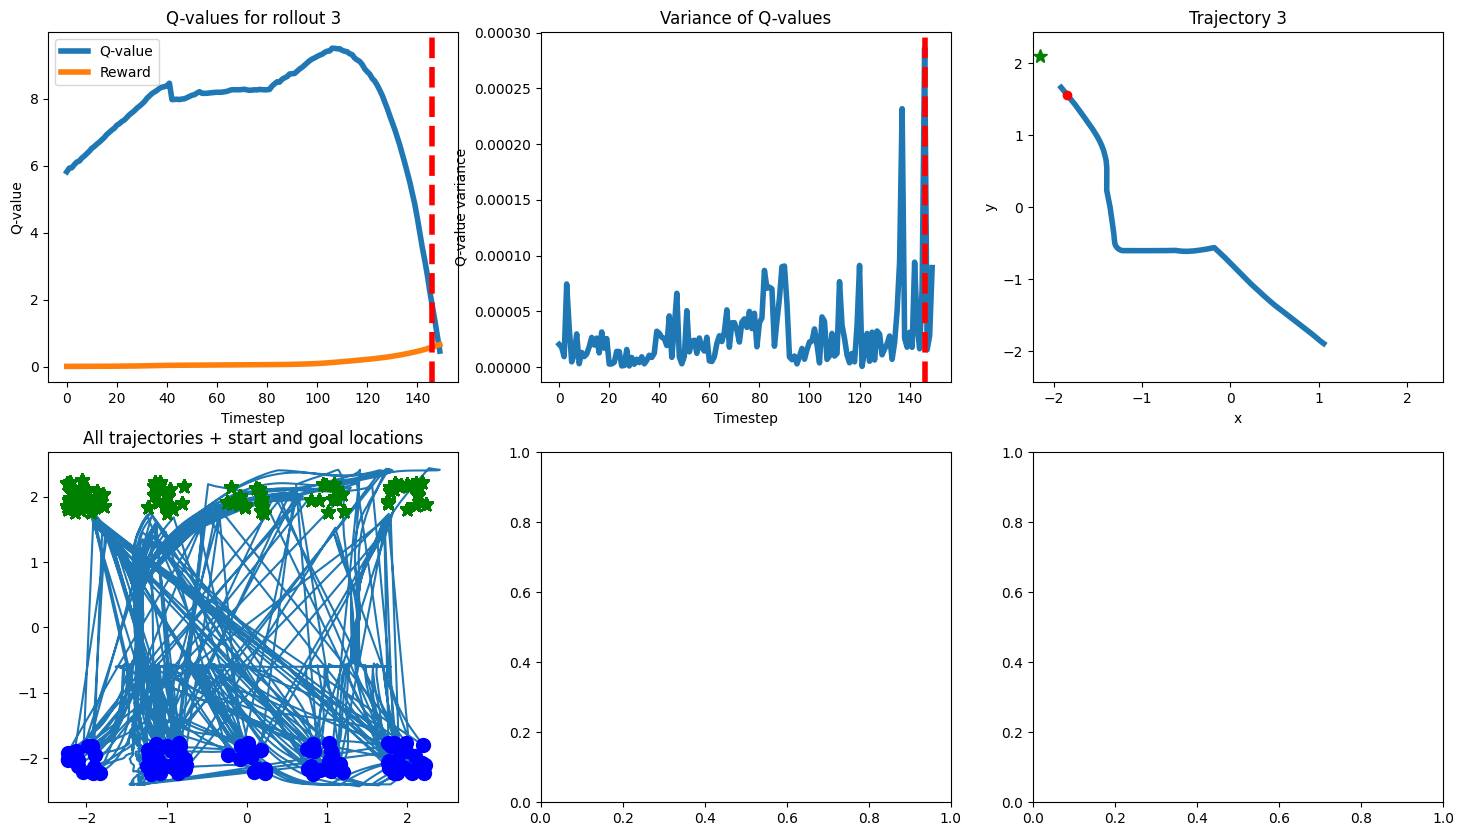

In [42]:
start_indices = np.where(dataset[:][-1])[0]
start_indices += 1
start_indices = np.insert(start_indices, 0, 0)

traj_indx = 3
start = start_indices[traj_indx]
end = start_indices[traj_indx + 1]

all_obss, all_actions, all_next_obss, all_next_actions, all_rewards, all_dones = dataset[:]

min_x = torch.min(all_obss[:, 0])
max_x = torch.max(all_obss[:, 0])
min_y = torch.min(all_obss[:, 1])
max_y = torch.max(all_obss[:, 1])

obss = all_obss[start:end].numpy()
actions = all_actions[start:end].numpy()
rewards = all_rewards[start:end].numpy()

print(obss.shape, actions.shape, rewards.shape)

T = np.arange(len(obss))

# compute q_values along that trajectory
q_values = apply_q_fn(q_params, obss, actions)
q_values = jnp.squeeze(q_values, axis=-1)
print(q_values.shape)

plt.clf()
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# first subplot plot the q_values and rewards
axes[0].plot(T, q_values, label="Q-value", linewidth=4)
axes[0].plot(T, rewards, label="Reward", linewidth=4)
axes[0].legend()
axes[0].set_xlabel("Timestep")
axes[0].set_ylabel("Q-value")
axes[0].set_title(f"Q-values for rollout {traj_indx}")

# compute metric: var(Q(s, a+gaussian noise))
num_samples = 100

def apply_noise(params, state, action):
    noise = jax.random.normal(rng_key, (num_samples, 2)) * 0.1
    q = jax.vmap(lambda noise: apply_q_fn(params, state, action + noise))(noise)
    return q

def apply_action(params, states, actions):
    q = jax.vmap(lambda state, action: apply_noise(params, state, action))(
        states, actions
    )
    return q

q = apply_action(q_params, obss, actions)
q = jnp.squeeze(q, axis=-1)
# [T, noise_samples]
variance = jnp.var(q, axis=1)
print(variance.shape)

axes[1].plot(T, variance, linewidth=4)
axes[1].set_xlabel("Timestep")
axes[1].set_ylabel("Q-value variance")
axes[1].set_title("Variance of Q-values")

# plot the trajectory
traj_xy = obss[:, :2]
(traj_plot,) = axes[2].plot(traj_xy[:, 0], traj_xy[:, 1], linewidth=4)
goal_location = dataset[start][0][-2:]
axes[2].plot(goal_location[0], goal_location[1], "g*", markersize=10)
axes[2].set_xlim(min_x, max_x)
axes[2].set_ylim(min_y, max_y)
axes[2].set_xlabel("x")
axes[2].set_ylabel("y")
axes[2].set_title(f"Trajectory {traj_indx}")

# find location with max variance
max_var_idx = np.argmax(variance)
# set vline there
axes[0].axvline(x=max_var_idx, color="r", linestyle="--", linewidth=4)
axes[1].axvline(x=max_var_idx, color="r", linestyle="--", linewidth=4)
# make a point in axes[2]
max_var_point = obss[max_var_idx, :2]
axes[2].plot(max_var_point[0], max_var_point[1], "ro")

# plot all of the trajectorie
all_obss = dataset[:][0].numpy()
all_goal_locations = all_obss[:, -2:]
all_start_locations = all_obss[start_indices[:-1], :2]
axes[3].plot(all_obss[:, 0], all_obss[:, 1])
axes[3].plot(all_goal_locations[:, 0], all_goal_locations[:, 1], "g*", markersize=10)
axes[3].plot(all_start_locations[:, 0], all_start_locations[:, 1], "bo", markersize=10)
axes[3].set_title("All trajectories + start and goal locations")

# plot the density of states conditioned on goal
sample_goal = all_goal_locations[start_indices[90]]
rng_keys = jax.random.split(rng_key, all_obss.shape[0])
density = jax.vmap(
    lambda obs, key: estimate_density(vae_params, key, obs, sample_goal, vae_config.kl_div_weight, vae_config.latent_size)
)(all_obss[:, :2], rng_keys)
print(f"min density: {np.min(density)}, max density: {np.max(density)}")


scat = axes[4].scatter(all_obss[:, 0], all_obss[:, 1], c=density, cmap="viridis")
axes[4].plot(sample_goal[0], sample_goal[1], "g*", markersize=10)
axes[4].set_title("GC Density, Goal: (x, y) = " + str(sample_goal))
axes[4].set_xlabel("x")
axes[4].set_ylabel("y")
axes[4].set_xlim(min_x, max_x)
axes[4].set_ylim(min_y, max_y)
fig.colorbar(scat, ax=axes[4])  

In [ ]:
from collections import Counter
start_goal = all_obss[start_indices[:-1], -2:]
print(start_goal.shape)
Counter(start_goal.sum(axis=-1).tolist())
Counter(all_goal_locations.sum(axis=-1).tolist())

(100, 2)


Counter({0.21714340896865436: 999,
         4.308837197806755: 999,
         4.165924230834062: 999,
         1.958908693241645: 999,
         3.6730622004479376: 999,
         3.986351067352034: 999,
         4.135198212828259: 999,
         0.1346858664346735: 999,
         1.9682568325571312: 999,
         4.288305885045938: 600,
         4.410267337047719: 570,
         4.231309871976576: 490,
         3.6882585979758913: 477,
         4.048842200516791: 414,
         3.8733769614702416: 396,
         2.0281928253277424: 308,
         1.8073716783485634: 277,
         2.7781830932591616: 269,
         2.9925080073988672: 269,
         2.076058121131373: 229,
         1.1518863334461238: 223,
         1.6754330461069542: 217,
         1.1455363399461267: 209,
         1.9334255986112687: 209,
         0.6089973690138797: 206,
         0.8471553086870259: 204,
         1.914158999686661: 202,
         -0.3022329229412044: 200,
         -0.1101372449791298: 199,
         1.84286740624

In [51]:
vl_1 = ax1.axvline(x=0)
vl_2 = ax2.axvline(x=0)

def animate(i):
    vl_1.set_xdata([i, i])
    vl_2.set_xdata([i, i])
    traj_plot.set_data(xy[:i, 0], xy[:i, 1])

print("saving anim")
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

ani = animation.FuncAnimation(fig, animate, frames=T, interval=10, blit=True)
ani.save("movie.gif", fps=30, writer='imagemagick')

# %matplotlib notebook
# from IPython.display import HTML
# HTML(ani.to_jshtml())

MovieWriter imagemagick unavailable; using Pillow instead.


saving anim
